This notebook reads one (or more) OTEANN results file(s) and vizualises them

In [1]:
import os
import time
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
import codecs

def get_unique_chars(filename):
    unique_chars = set(char for line in codecs.open(filename, encoding="UTF-8") for char in line)
    return unique_chars

def display_orthography_letters(config):

    languages = config['languages']

    for lang in languages:
        filename = config['root_dir'] + '/' + config['subdatasets_dir'] + '/' + lang + '_' + config['subdataset']
        filename_g = filename + '_graphemes.tmp'
        filename_p = filename + '_phonemes.tmp'

        df = pd.read_csv(filename)

        df.Word.to_csv(filename_g, index=False, header=None)
        df_g = pd.read_csv(filename_g)

        df.Pronunciation.to_csv(filename_p, index=False, header=None)
        df_p = pd.read_csv(filename_p)

        unique_graphemes = get_unique_chars(filename_g)
        unique_phonemes = get_unique_chars(filename_p)
        
        os.remove(filename_g)
        os.remove(filename_p)
        print('%s, n_phonemes:%d, n_graphemes:%d' % (
            lang, len(unique_phonemes)-1, len(unique_graphemes)-1)) # -1 is for ''\n'
        print("graphemes:", sorted(unique_graphemes))
        print("phonemes:", sorted(unique_phonemes))
        print("-------------------------------")
#display_orthography_letters(config)

In [3]:
# These first configuration parameters are hyperparameters that we will need to tune
CONFIG = {            
    'n_train': 0,
}

ROOT_DIR = os.getcwd()

# These other configuration parameters will not be tuned
def extend_config(config): 
    config['languages'] = ['ent', 'eno','ar', 'br', 'de', 'en', 'eo', 'es', 'fi', 'fr', 'fro', 'it', 'ko', 'nl', 'pt', 'ru', 'sh', 'tr', 'zh']
    config['tasks'] = ['write', 'read']
    #config['languages'] = ['ent', 'eno', 'br', 'fr']
    #config['languages'] = ['ent']    
    config['n_test'] = 1000
    config['n_samples'] = config['n_train'] + config['n_test']
    config['label'] = 'oteann' + '_' + str(config['n_samples'])
    config['subdatasets_dir'] = 'subdatasets'
    config['subdataset'] = 'wikt_samples.csv' # postfix from fonetik.fr 
    config['root_dir'] = os.getcwd()    
    config['trial_dir'] = os.getcwd() 
    config['trial_filename'] = config['trial_dir'] + '/' + config['label']
    config['results_filename'] = config['trial_filename'] + '_results.csv'
    return config
        
config = extend_config(CONFIG)

In [4]:
def display_textual_results(config):
    df_results = pd.read_csv(config['results_filename']) 
    # display the "write" results of the different languages
    # the best writing-system is on the first line
    # the worst writing-system is on the last line
    print('scoring of the orthograpies with respect to "write" task:')
    print(df_results[df_results.task == 'write'].sort_values('test_accuracy', ascending=False))
    print()
    # display the "read" results of the different languages
    # the best reading-system is on the first line
    # the worst reading-system is on the last line
    print('scoring of the orthograpies with respect to "read" task:')
    print(df_results[df_results.task == 'read'].sort_values('test_accuracy', ascending=False))

In [5]:
def display_text_results(config):
    df_results = pd.read_csv(config['results_filename']) 
    # display the "write" results oe the different languages
    print("|-----------|------------|------------|")
    print("|orthography| write score| read score |")
    print("|-----------|------------|------------|")
    for lang in df_results.lang.unique():
        dfl = df_results[df_results.lang == lang]
        print("|    %3s    | %04.1f ± %2.1f | %04.1f ± %2.1f |" % (
              lang.ljust(3),
              round(dfl[dfl.task == 'write'].mean()*100, 1),
              round(dfl[dfl.task == 'write'].std()*100, 1),
              round(dfl[dfl.task == 'read'].mean()*100, 1),
              round(dfl[dfl.task == 'read'].std()*100, 1))
             )
        if lang == 'eno':
            print("|-----------|------------|------------|")
    print("|-----------|------------|------------|")

In [6]:
def display_latex_results(config):

    print('\\begin{figure}[h]')
    print('\centering')
    print('\captionsetup{justification=centering}')
    print('\\begin{floatrow}')
    print('\\capbtabbox{%')
    print('\\begin{tabular}{c c c}')
    print('\\hline')
    print('\\textbf{Language} & \\textbf{Write} & \\textbf{Read}\\\\')
    print('\\hline\hline')
    
    df_results = pd.read_csv(config['results_filename']) 
    # display the "write" results oe the different languages
    n = config['n_train']
    
    for lang in df_results.lang.unique():
        dfl = df_results[df_results.lang == lang]
        print("%s & %4.1f ± %2.1f & %4.1f ± %2.1f \\\\\\hline" % (
              lang.ljust(3),
              round(dfl[dfl.task == 'write'].mean()*100, 1),
              round(dfl[dfl.task == 'write'].std()*100, 1),
              round(dfl[dfl.task == 'read'].mean()*100, 1),
              round(dfl[dfl.task == 'read'].std()*100, 1))
             )
        if lang == 'eno':
            print('\\hline')  
    print('\\end{tabular}')
    print('}{%')
    print('  \\caption{Phonemic transparency scores. \\newline ' + 
          '(OTEANN trained with $' + f'{n:,}' + '$ samples)}%')
    print('  \\label{tab:tabular_results_' + str(config['n_samples']) + '}')
    print('}')
    print('\\ffigbox{%')
    print('\\includegraphics[width=7.5cm]{oteann_' + 
          str(config['n_samples']) + '_results.png}%')
    print('}{%')
    print('  \\caption{Scatterplot of the mean scores. \\newline ' + 
          '(OTEANN trained with $' + f'{n:,}' + '$ samples)}%')
    print('  \\label{fig:figure_results_' + str(config['n_samples']) + '}')
    print('}')
    print('\\end{floatrow}')
    print('\\end{figure}')

In [7]:
def display_barplot_results(config):
    
    df = pd.read_csv(config['results_filename'])
    
    sns.set(style="whitegrid")
    current_palette = sns.color_palette()
    for task in config['tasks']:
        df_o = df[df.task==task].sort_values(by='lang')
        df_o = df_o[['task', 'lang', 'test_accuracy']]
        df_o['test_accuracy']=df_o['test_accuracy']*100
        df_o = round(df_o.groupby('lang', as_index=False).mean())
        sns.palplot(current_palette)
        ax = sns.barplot(x="lang", y="test_accuracy",
                         data=df_o, palette=current_palette)
        # add the accuracy number on the top of each bar
        i=0
        for index, row in df_o.iterrows():
            ax.text(i, row.test_accuracy+1, str(round(row.test_accuracy)), color='black', ha="center")
            i+=1
        plt.title(task.capitalize())
        plt.ylim(0, 100)
        plt.show()

In [8]:
def display_boxplot_results(config):
    
    df = pd.read_csv(config['results_filename'])
    
    sns.set(style="whitegrid")
    current_palette = sns.color_palette()
    for task in config['tasks']:
        df_o = df[df.task==task].sort_values(by='lang')
        df_o = df_o[['task', 'lang', 'test_accuracy']]
        df_o['test_accuracy']=df_o['test_accuracy']*100
        #df_o = df_o.groupby('lang', as_index=False).mean()
        sns.palplot(current_palette)
        ax = sns.boxplot(x="lang", y="test_accuracy",
                         data=df_o, palette=current_palette)
        # add the accuracy number on the top of each bar
        i=0
        for index, row in df_o.iterrows():
            #ax.text(i, row.test_accuracy+1, str(round(row.test_accuracy)), color='black', ha="center")
            i+=1
        plt.title(task.capitalize())
        plt.ylim(0, 100)
        plt.show()

In [9]:
def display_config(config):
    n = config['n_train']
    print('n_train:', f'{n:,}')
    df_results = pd.read_csv(config['results_filename'])
    n_tasks = len(df_results['task'].unique())
    n_langs = len(df_results['lang'].unique())
    print('result file:')
    print('* n_tasks: %d' % n_tasks)
    print('* n_langs: %d' % n_langs)
    print('* n_rows: %d' % df_results.shape[0])
    if n_tasks > 0 and n_langs > 0:
        nb_episodes = float(df_results.shape[0]) / (n_tasks * n_langs)
        print('* nb_episodes: %.2f' % nb_episodes)

In [10]:
def label_point(x, y, val, ax):
    a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
    for i, point in a.iterrows():
        ax.text(point['x']+2, point['y'], str(point['val']))

def display_scatterplot_results(config):
    
    df_results = pd.read_csv(config['results_filename']) 
    
    df_results = df_results[~df_results['lang'].str.contains('eno')]
    df_results = df_results[~df_results['lang'].str.contains('ent')]
    
    df_results = df_results.groupby(['lang','task'], as_index=False).mean()
    
    df_w = df_results[df_results.task=='write']
    df_w.rename(columns={"task": "write"})
    df_r = df_results[df_results.task=='read']
    df_r.rename(columns={"task": "read"})

    df_res = df_w.merge(df_r, left_on='lang', right_on='lang')
    df_res = df_res.rename(columns={"test_accuracy_x": "write_accuracy", "test_accuracy_y": "read_accuracy"})
    df_res['write_accuracy'] = df_res['write_accuracy'] * 100
    df_res['read_accuracy'] = df_res['read_accuracy'] * 100

    sns.set_theme(color_codes=True)
    
    ax = sns.lmplot(
        data=df_res, # Data source
        x='write_accuracy',
        y='read_accuracy',
        fit_reg=False, # Don't fix a regression line
        height=5,
        aspect=1) # size and dimension
    
    
    #plt.rcParams['figure.dpi'] = 300
    plt.rcParams['savefig.dpi'] = 300
    
    #plt.title('Transparency of the orthographies (with %d training samples)' % config['n_train'])
    # Set x-axis label
    plt.xlabel('Write accuracy')
    # Set y-axis label
    plt.ylabel('Read accuracy')
    
    label_point(df_res.write_accuracy, df_res.read_accuracy, df_res.lang, plt.gca())
    
    ax.set(xlim=(-1.5, 101.5))
    ax.set(ylim=(-1.5, 101.5))        

    #plt.subplots_adjust(left=-0.1, bottom=-0.1, right=1.05, top=1.05)
    plt.tight_layout()
    figure_file = 'oteann_' + str(config['n_samples']) + '_results.png'
    plt.show()
    plt.savefig(figure_file)

In [11]:
def display_aggregated_scatterplot_results(config, n_trains):    
    
    #sns.set(rc={'figure.figsize':(6.5, 6.5)})
    sns.set(rc={'figure.figsize':(7, 7)})
    #plt.rcParams['figure.dpi'] = 300
    plt.rcParams['savefig.dpi'] = 300

    
    df_res = pd.DataFrame(columns=['n_train', 'orthography', 'write_accuracy', 'read_accuracy'])    
    
    for n_train in n_trains:
        config['n_train'] = n_train
        config = extend_config(config)
        df_results = pd.read_csv(config['results_filename']) 
        
        df_results = df_results[~df_results['lang'].str.contains('eno')]
        df_results = df_results[~df_results['lang'].str.contains('ent')]

        df_results = df_results.rename(columns={'lang': 'orthography'})
        df_results = df_results.groupby(['orthography','task'], as_index=False).mean()

        df_w = df_results[df_results.task=='write']
        df_w.rename(columns={"task": "write"})
        df_r = df_results[df_results.task=='read']
        df_r.rename(columns={"task": "read"})
        
        df_res_i = df_w.merge(df_r, left_on='orthography', right_on='orthography')
        df_res_i = df_res_i.rename(columns={"test_accuracy_x": "write_accuracy", "test_accuracy_y": "read_accuracy"})
        df_res_i = df_res_i.drop(columns=['task_x', 'task_y'])
        df_res_i['n_train'] = n_train

        df_res = df_res.append(df_res_i)
    df_res = df_res.rename(columns={'n_train': 'Training samples'})
    df_res = df_res.rename(columns={'orthography': 'Orthography'})
        
    ax = sns.scatterplot(
        data=df_res, # Data source
        x='write_accuracy',
        y='read_accuracy',
        hue='Orthography',
        size='Training samples',
        #alpha=0.70,
        legend='full',
        size_order=[1000, 2000, 3000, 5000, 10000]
    )

    #plt.title('Transparency of the orthographies (with %d training samples)' % config['n_train'])
    # Set x-axis label
    plt.xlabel('Write accuracy')
    # Set y-axis label
    plt.ylabel('Read accuracy')

    
    
    #df_res_last = df_res[df_res.n_train == n_trains[-1]]
    #label_point(df_res_last.write_accuracy, df_res_last.read_accuracy, df_res_last.lang, plt.gca())

    ax.set(xlim=(-0.01, 1.015))
    ax.set(ylim=(-0.01, 1.015))
    #plt.figure(figsize=(150, 150))
    
    
    #handles, labels = ax.legend_elements(prop="lang", alpha=0.6)
    #legend2 = ax.legend(handles, labels, loc="upper right", title="Orthography")

    plt.subplots_adjust(left=-0.2, bottom=-0.1, right=1.05, top=1.05)
    plt.tight_layout()
    plt.legend(loc='lower right')
    plt.legend(bbox_to_anchor=(1.01, 1),borderaxespad=0)
    figure_file = 'oteann_results.png'
    plt.show()
    plt.savefig(figure_file)

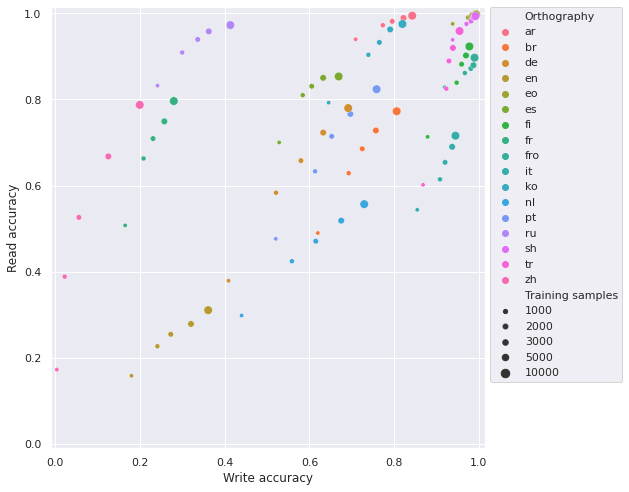

<Figure size 504x504 with 0 Axes>

In [12]:
n_trains = [1000, 2000, 3000, 5000, 10000]

for n_train in n_trains:
    config['n_train'] = n_train
    config = extend_config(config)
display_aggregated_scatterplot_results(config, n_trains)

########################################


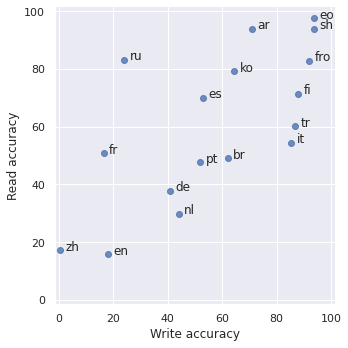

########################################


<Figure size 504x504 with 0 Axes>

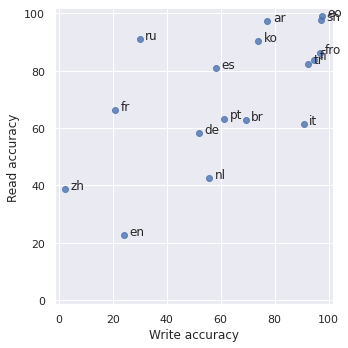

########################################


<Figure size 504x504 with 0 Axes>

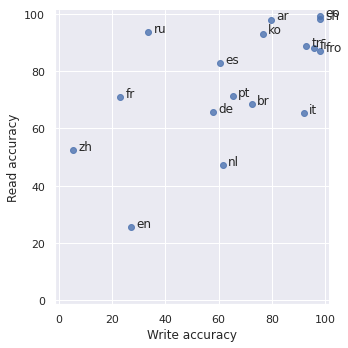

########################################


<Figure size 504x504 with 0 Axes>

In [ ]:
results = [1000, 2000, 3000, 5000, 10000]

for n_train in results:
    print('########################################')
    config = { 
        'n_train': n_train
    }
    config = extend_config(config)
    display_scatterplot_results(config)

In [ ]:
results = [1000, 2000, 3000, 5000, 10000]

for n_train in results:
    print('########################################')
    config = { 
        'n_train': n_train
    }
    config = extend_config(config)
    #display_textual_results(config)
    display_config(config)
    display_text_results(config)
    display_barplot_results(config)
    display_boxplot_results(config)
    display_latex_results(config)
    display_scatterplot_results(config)
    print('########################################')

In [ ]:
def summarizes_dataset(language, debug=False):
    if debug:
        print('lang:', language)
    result = {
        'language' : language
    }
    df = pd.read_csv('subdatasets/'+ language +'_wikt_samples.csv')
    if debug:
        print('df.shape:', df.shape)
        print(df.head(3))
    word_chars = ''.join(df['Word'].values)
    pron_chars = ''.join(df['Pronunciation'].values)
    wtoi = { ch:i for i,ch in enumerate(word_chars) }
    ptoi = { ch:i for i,ch in enumerate(pron_chars) }
    if debug:
        print('wtoi:', wtoi)
        print('')
        print('ptoi:', ptoi)
    result['n_rows'] = df.shape[0]
    samples = df.shape[0]
    result['n_phonemes'] = len(ptoi)
    result['n_graphemes'] = len(wtoi)
    df['Word_len'] = df['Word'].str.len()
    df['Pron_len'] = df['Pronunciation'].str.len()
    result['phonemes_mean_len'] = int(df['Pron_len'].mean()*10)/10
    result['phonemes_mean_std'] = int(df['Pron_len'].std()*10)/10
    result['graphemes_mean_len'] = int(df['Word_len'].mean()*10)/10
    result['graphemes_mean_std'] = int(df['Word_len'].std()*10)/10
    
    latex_str = language + ' & ' +  \
                f'{samples:,}' + ' & ' +  \
                str(result['n_phonemes']) + ' & ' +  \
                str(result['n_graphemes']) + ' & ' +  \
                str(result['phonemes_mean_len']) + ' ± ' + str(result['phonemes_mean_std']) + ' & ' +  \
                str(result['graphemes_mean_len']) + ' ± ' + str(result['graphemes_mean_std']) + ' \\\\' 
    print(latex_str)
    
    return result

In [ ]:
res_datasets = []
languages = ['ar', 'br', 'de', 'en', 'eo', 'es', 'fi', 'fr', 'fro', 
             'it', 'ko', 'nl', 'pt', 'ru', 'sh', 'tr', 'zh',
             'eno', 'ent' ]
for lang in languages:
    try:
        result = summarizes_dataset(lang)
        res_datasets.append(result)
    except:
        print('pb for:', lang)
    df_datasets = pd.DataFrame(res_datasets)
df_datasets

In [ ]:
def rgb_to_hex(rgb):
    return '#' + '%02x%02x%02x' % rgb

In [ ]:
def display_colored_scatterplot_results(config):
    
    df_results = pd.read_csv(config['results_filename']) 
    
    df_results = df_results[~df_results['lang'].str.contains('eno')]
    df_results = df_results[~df_results['lang'].str.contains('ent')]
    
    df_results = df_results.groupby(['lang','task'], as_index=False).mean()
    
    df_w = df_results[df_results.task=='write']
    df_w.rename(columns={"task": "write"})
    df_r = df_results[df_results.task=='read']
    df_r.rename(columns={"task": "read"})

    df_res = df_w.merge(df_r, left_on='lang', right_on='lang')
    df_res = df_res.rename(columns={"test_accuracy_x": "write_accuracy", "test_accuracy_y": "read_accuracy"})
    df_res['write_accuracy'] = df_res['write_accuracy'] * 100
    df_res['read_accuracy'] = df_res['read_accuracy'] * 100
    
    df_res['color'] = "darkred"
    df_res.loc[df_res['lang']=='ar', 'color'] = rgb_to_hex((247, 113, 137))
    df_res.loc[df_res['lang']=='br', 'color'] = rgb_to_hex((248, 118, 59))
    df_res.loc[df_res['lang']=='de', 'color'] = rgb_to_hex((210, 142, 50))
    df_res.loc[df_res['lang']=='en', 'color'] = rgb_to_hex((183, 153, 50))
    df_res.loc[df_res['lang']=='eo', 'color'] = rgb_to_hex((158, 162, 49))
    df_res.loc[df_res['lang']=='es', 'color'] = rgb_to_hex((124, 170, 49))
    df_res.loc[df_res['lang']=='fi', 'color'] = rgb_to_hex((49, 179, 69))
    
    df_res.loc[df_res['lang']=='fr', 'color'] = rgb_to_hex((52, 176, 129))
    df_res.loc[df_res['lang']=='fro', 'color'] = rgb_to_hex((53, 174, 154))
    df_res.loc[df_res['lang']=='it', 'color'] = rgb_to_hex((54, 172, 173))
    df_res.loc[df_res['lang']=='ko', 'color'] = rgb_to_hex((56, 170, 193))
    
    df_res.loc[df_res['lang']=='nl', 'color'] = rgb_to_hex((58, 166, 221))
    
    df_res.loc[df_res['lang']=='pt', 'color'] = rgb_to_hex((118, 153, 244))
    df_res.loc[df_res['lang']=='ru', 'color'] = rgb_to_hex((176, 135, 244))
    df_res.loc[df_res['lang']=='sh', 'color'] = rgb_to_hex((223, 109, 244))
    df_res.loc[df_res['lang']=='tr', 'color'] = rgb_to_hex((245, 99, 216))
    df_res.loc[df_res['lang']=='zh', 'color'] = rgb_to_hex((246, 106, 178))
    
    sns.set_theme(color_codes=True)
    
    n_train = config['n_train']
    if n_train == 10000:
        s=60
    elif n_train == 5000:
        s=50
    elif n_train == 3000:
        s=40
    elif n_train == 2000:
        s=30
    elif n_train == 1000:
        s=20
    else:
        print('display_colored_scatterplot_results: ERRROR unexptected size: %d' % n_train)
        s=100
        
    ax = sns.lmplot(
        data=df_res, # Data source
        x='write_accuracy',
        y='read_accuracy',
        fit_reg=False, # Don't fix a regression line
        height=5,
        aspect=1,
        scatter_kws={'facecolors':df_res['color'],
                     #'alpha':0.7, 
                     's':s,
                     'linewidths':0 }) # size and dimension
    
    
    #plt.rcParams['figure.dpi'] = 300
    plt.rcParams['savefig.dpi'] = 300
    
    #plt.title('Transparency of the orthographies (with %d training samples)' % config['n_train'])
    # Set x-axis label
    plt.xlabel('Write accuracy')
    # Set y-axis label
    plt.ylabel('Read accuracy')
    
    label_point(df_res.write_accuracy, df_res.read_accuracy, df_res.lang, plt.gca())
    
    ax.set(xlim=(-1.5, 101.5))
    ax.set(ylim=(-1.5, 101.5))        

    #plt.subplots_adjust(left=-0.1, bottom=-0.1, right=1.05, top=1.05)
    plt.tight_layout()
    figure_file = 'oteann_results.png'
    plt.show()
    plt.savefig(figure_file)

In [ ]:
n_trains = [1000, 2000, 3000, 5000, 10000]


for n_train in n_trains:
    config['n_train'] = n_train
    config = extend_config(config)
    display_colored_scatterplot_results(config)